In [1]:
import pandas as pd

df = pd.read_csv(r"C:\Users\ASUS\OneDrive\Desktop\EXEMPTED\CODED\ML\T1\traffic flow\traffic.csv")
df['DateTime'] = pd.to_datetime(df['DateTime'])     # convert datetime
df = df.sort_values('DateTime')  

In [2]:
import numpy as np

def create_sequences(data, seq_len=24):
    X, y = [], []

    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])                 # input sequence
        y.append(data[i+1:i+seq_len+1])             # next-step targets

    return np.array(X), np.array(y)


In [4]:
!pip install torch transformers datasets accelerate peft bitsandbytes trl

In [7]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class TimeSeriesLLM(nn.Module):
    def __init__(self, input_dim=1, d_model=128, n_heads=8, num_layers=4):
        super().__init__()

        self.input_projection = nn.Linear(input_dim, d_model)

        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.input_projection(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        return self.output_layer(x)



Training for Junction 1
Epoch 0 Loss: 371618.8579
Epoch 1 Loss: 240862.6094
Epoch 2 Loss: 240987.9143
Epoch 3 Loss: 240580.9177
Epoch 4 Loss: 240830.3961
Epoch 5 Loss: 240924.0402
Epoch 6 Loss: 240794.9548
Epoch 7 Loss: 241150.8382
Epoch 8 Loss: 241005.2249
Epoch 9 Loss: 241401.3427
Epoch 10 Loss: 240951.2689
Epoch 11 Loss: 240845.4157
Epoch 12 Loss: 241217.9254
Epoch 13 Loss: 240997.0058
Epoch 14 Loss: 240885.0214
Epoch 15 Loss: 240684.0929
Epoch 16 Loss: 240781.2703
Epoch 17 Loss: 240890.7637
Epoch 18 Loss: 241284.5437
Epoch 19 Loss: 241011.7106
MAE: 18.973953247070312
RMSE: 23.084780798010353


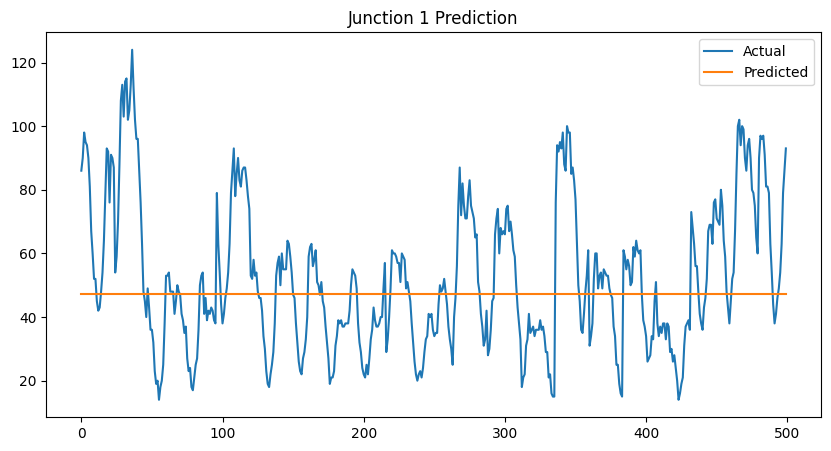


Training for Junction 2
Epoch 0 Loss: 13891.1477
Epoch 1 Loss: 3921.8863
Epoch 2 Loss: 3787.3570
Epoch 3 Loss: 3543.4062
Epoch 4 Loss: 3480.9478
Epoch 5 Loss: 3471.6297
Epoch 6 Loss: 3347.2800
Epoch 7 Loss: 3281.6085
Epoch 8 Loss: 3127.1218
Epoch 9 Loss: 2748.6176
Epoch 10 Loss: 2664.8395
Epoch 11 Loss: 2606.9601
Epoch 12 Loss: 2443.6681
Epoch 13 Loss: 1946.6923
Epoch 14 Loss: 1511.1203
Epoch 15 Loss: 1226.7161
Epoch 16 Loss: 1082.8248
Epoch 17 Loss: 998.2194
Epoch 18 Loss: 845.1538
Epoch 19 Loss: 786.7394
MAE: 0.7893908619880676
RMSE: 1.0306692511113653


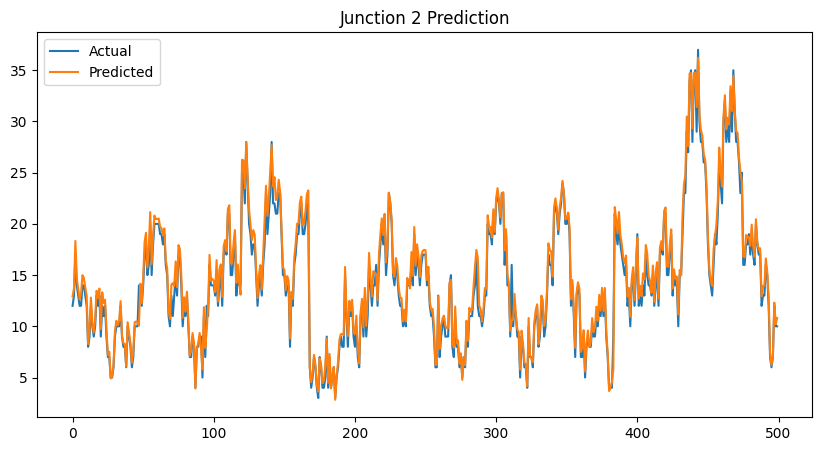


Training for Junction 3
Epoch 0 Loss: 30136.8800
Epoch 1 Loss: 15765.6118
Epoch 2 Loss: 15332.2538
Epoch 3 Loss: 14237.0344
Epoch 4 Loss: 13635.1285
Epoch 5 Loss: 14403.5574
Epoch 6 Loss: 14547.9852
Epoch 7 Loss: 14663.2784
Epoch 8 Loss: 13854.9639
Epoch 9 Loss: 13327.8707
Epoch 10 Loss: 13688.1680
Epoch 11 Loss: 13337.0356
Epoch 12 Loss: 13180.6901
Epoch 13 Loss: 14259.9707
Epoch 14 Loss: 14116.2566
Epoch 15 Loss: 13649.5650
Epoch 16 Loss: 13482.0637
Epoch 17 Loss: 13788.4366
Epoch 18 Loss: 13400.3412
Epoch 19 Loss: 13257.0520
MAE: 3.286794662475586
RMSE: 5.545562158953182


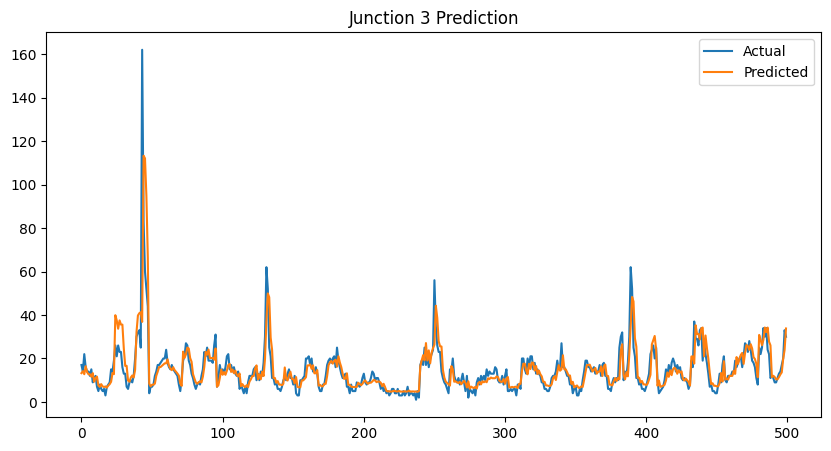


Training for Junction 4
Epoch 0 Loss: 1527.0046
Epoch 1 Loss: 1009.6474
Epoch 2 Loss: 963.9111
Epoch 3 Loss: 967.8533
Epoch 4 Loss: 942.8243
Epoch 5 Loss: 943.9275
Epoch 6 Loss: 934.1854
Epoch 7 Loss: 947.8655
Epoch 8 Loss: 942.8504
Epoch 9 Loss: 929.7014
Epoch 10 Loss: 923.6231
Epoch 11 Loss: 889.9787
Epoch 12 Loss: 859.7999
Epoch 13 Loss: 834.6660
Epoch 14 Loss: 799.8701
Epoch 15 Loss: 753.3832
Epoch 16 Loss: 726.0904
Epoch 17 Loss: 606.9137
Epoch 18 Loss: 397.1647
Epoch 19 Loss: 297.4919
MAE: 0.9270159602165222
RMSE: 1.182155326790666


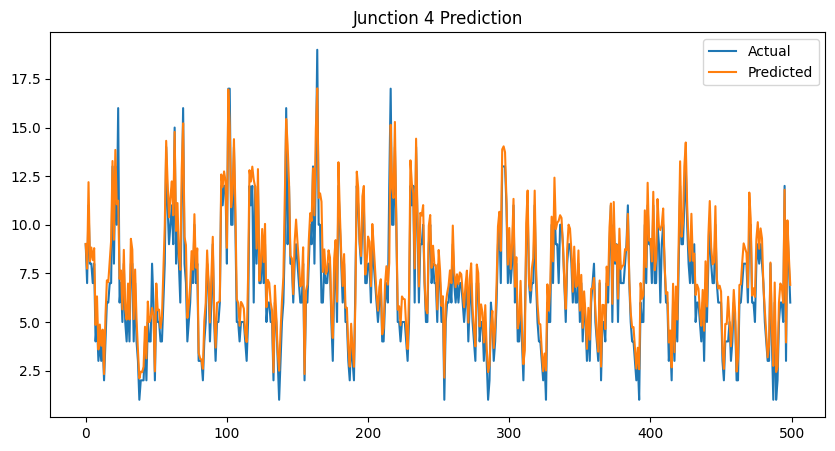

In [8]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

junction_results = {}

for junction in df['Junction'].unique():           # loop through each junction
    
    print(f"\nTraining for Junction {junction}")
    
    j_df = df[df['Junction'] == junction]          # filter data for that junction
    
    values = j_df['Vehicles'].values
    
    X, y = create_sequences(values, seq_len=24)    # create sequences
    
    X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)
    
    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    model = TimeSeriesLLM()                        # new model for this junction
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    
    # ---- TRAINING ----
    for epoch in range(20):
        total_loss = 0
        
        for batch_x, batch_y in loader:
            
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch} Loss: {total_loss:.4f}")
    
    # ---- EVALUATION ----
    model.eval()
    
    preds = []
    actual = []
    
    with torch.no_grad():
        for batch_x, batch_y in loader:
            out = model(batch_x)
            preds.append(out.numpy())
            actual.append(batch_y.numpy())
    
    preds = np.concatenate(preds)
    actual = np.concatenate(actual)
    
    mae = mean_absolute_error(actual.flatten(), preds.flatten())
    rmse = np.sqrt(mean_squared_error(actual.flatten(), preds.flatten()))
    
    print("MAE:", mae)
    print("RMSE:", rmse)
    
    junction_results[junction] = (mae, rmse)
    
    # ---- GRAPH ----
    plt.figure(figsize=(10,5))
    plt.plot(actual.flatten()[:500], label='Actual')
    plt.plot(preds.flatten()[:500], label='Predicted')
    plt.title(f"Junction {junction} Prediction")
    plt.legend()
    plt.show()


In [9]:
print("\nfinal junction wise results:")
for j, (mae, rmse) in junction_results.items():
    print(f"Junction {j}: MAE={mae:.3f}, RMSE={rmse:.3f}")



final junction wise results:
Junction 1: MAE=18.974, RMSE=23.085
Junction 2: MAE=0.789, RMSE=1.031
Junction 3: MAE=3.287, RMSE=5.546
Junction 4: MAE=0.927, RMSE=1.182


In [10]:
junction = 1
j_df = df[df['Junction'] == junction]

values = j_df['Vehicles'].values


In [12]:

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset


In [13]:
scaler = MinMaxScaler()
values = scaler.fit_transform(values.reshape(-1,1)).flatten()


In [14]:
def create_sequences(data, seq_len=24):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+1:i+seq_len+1])
    return np.array(X), np.array(y)

X, y = create_sequences(values, 24)


In [15]:
X = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [16]:
model = TimeSeriesLLM()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
criterion = torch.nn.MSELoss()

epochs = 40

for epoch in range(epochs):
    total_loss = 0
    for batch_x, batch_y in loader:
        
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss {total_loss:.4f}")


Epoch 1, Loss 16.8896
Epoch 2, Loss 1.0554
Epoch 3, Loss 0.6839
Epoch 4, Loss 0.5316
Epoch 5, Loss 0.4787
Epoch 6, Loss 0.4358
Epoch 7, Loss 0.4030
Epoch 8, Loss 0.3626
Epoch 9, Loss 0.3158
Epoch 10, Loss 0.2679
Epoch 11, Loss 0.2074
Epoch 12, Loss 0.1673
Epoch 13, Loss 0.1433
Epoch 14, Loss 0.1300
Epoch 15, Loss 0.1145
Epoch 16, Loss 0.1097
Epoch 17, Loss 0.1046
Epoch 18, Loss 0.0979
Epoch 19, Loss 0.0898
Epoch 20, Loss 0.0882
Epoch 21, Loss 0.0822
Epoch 22, Loss 0.0807
Epoch 23, Loss 0.0747
Epoch 24, Loss 0.0776
Epoch 25, Loss 0.0832
Epoch 26, Loss 0.0668
Epoch 27, Loss 0.0684
Epoch 28, Loss 0.0683
Epoch 29, Loss 0.0590
Epoch 30, Loss 0.0586
Epoch 31, Loss 0.0630
Epoch 32, Loss 0.0657
Epoch 33, Loss 0.0531
Epoch 34, Loss 0.0587
Epoch 35, Loss 0.0579
Epoch 36, Loss 0.0496
Epoch 37, Loss 0.0500
Epoch 38, Loss 0.0500
Epoch 39, Loss 0.0489
Epoch 40, Loss 0.0483


In [17]:
model.eval()

preds = []
actual = []

with torch.no_grad():
    for batch_x, batch_y in loader:
        out = model(batch_x)
        preds.append(out.numpy())
        actual.append(batch_y.numpy())

preds = np.concatenate(preds)
actual = np.concatenate(actual)


In [18]:
preds = scaler.inverse_transform(preds.reshape(-1,1)).flatten()
actual = scaler.inverse_transform(actual.reshape(-1,1)).flatten()


In [19]:
mae = mean_absolute_error(actual, preds)
rmse = np.sqrt(mean_squared_error(actual, preds))

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 3.4127511978149414
RMSE: 3.737294990760219


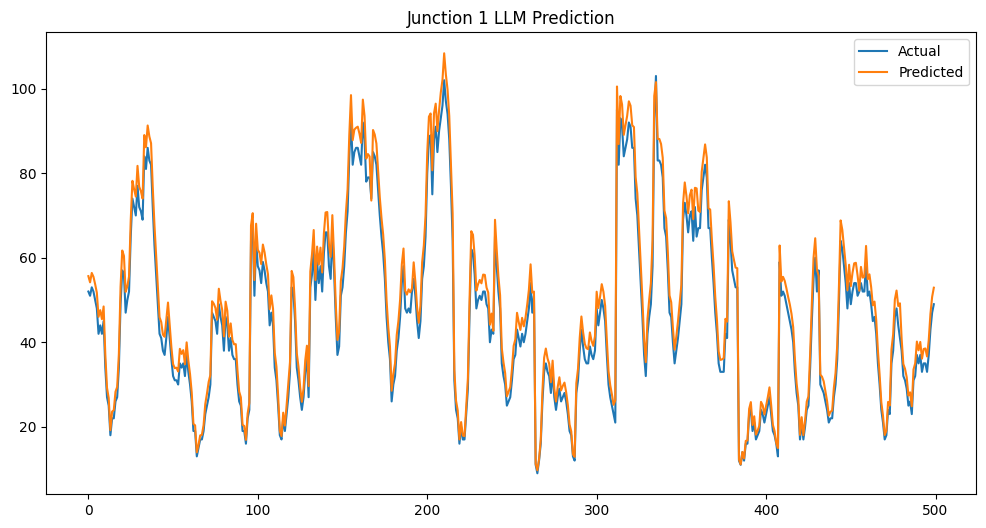

In [20]:
plt.figure(figsize=(12,6))
plt.plot(actual[:500], label="Actual")
plt.plot(preds[:500], label="Predicted")
plt.title(f"Junction {junction} LLM Prediction")
plt.legend()
plt.show()
